# Time Series Data Cleaning & EDA Notebook

## 0) Import Dependencies

In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler

# Time series libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Google credentials authentication libraries
from google.colab import auth
auth.authenticate_user()

# Bigquery imports and magics
  #BigQuery magics are used to run BigQuery SQL queries in a python environment.
  #These queries can also be run in the BigQuery UI
from google.cloud import bigquery
from google.cloud.bigquery import magics
magics.context.project = 'db-platform-sol' #update project name
client = bigquery.Client(project=magics.context.project)
%load_ext google.cloud.bigquery
bigquery.USE_LEGACY_SQL = False

## 1) Import data from BigQuery

In [ ]:
%%bigquery df
SELECT day, sales_total
FROM `db-platform-sol.adidas.model_daily`;

In [ ]:
df.head()

,day,sales_total
0,2020-01-01 00:00:00+00:00,1091138.50
1,2020-01-02 00:00:00+00:00,1190840.77
2,2020-01-05 00:00:00+00:00,1245424.51
3,2020-01-06 00:00:00+00:00,1131595.24
4,2020-01-07 00:00:00+00:00,1136180.44


In [ ]:
# rename column function
df = df.rename(columns ={'day': 'date','sales_total': 'sales'})

In [ ]:
df.date = df.date.astype(str)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    676 non-null    object 
 1   sales   676 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.7+ KB


We have almost 600 observations of monthly data spanning from 1972 - 2020

## 2) Data Exploration

### 2.1) Plot the time series

In [ ]:
# clean up index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [ ]:
# plot the target variable time series
df = df.sort_index()
fig = px.line(df['sales'],)
fig.show()

### 2.2) Check for missing data

In [ ]:
# check missing data
df.isna().value_counts()

sales
False    676
dtype: int64

### 2.3) Normalize the data

There are many different ways to normalize data. For this case, I'll use a standard scaling method of z-score normalization: removing the mean and dividing by the standard deviation. This will center my data around zero with a standard deviation of one.

Alternate methods include:
- Min-Max Scaler (puts data on 0-1 scale)
- Normalization (puts data on unit norm)
- Robust Scaler
- Max Abs Scaler


In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
df.sales = scaled

fig = px.line(df.sales)
fig.show()


### 2.4) Decompose the time series into trend, seasonality, and noise and plot the results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



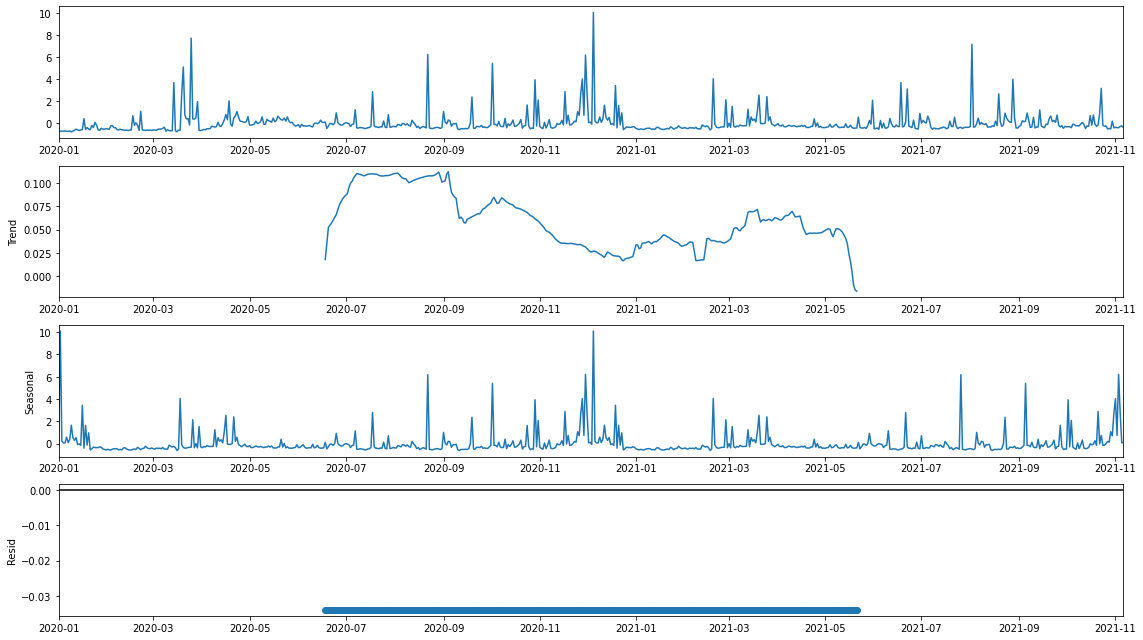

In [ ]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
# Change default figsize
plt.rc("figure",figsize=(16,9))


decompose_result_mult = seasonal_decompose(x = df, model="additive", freq = int(len(df)/2))

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

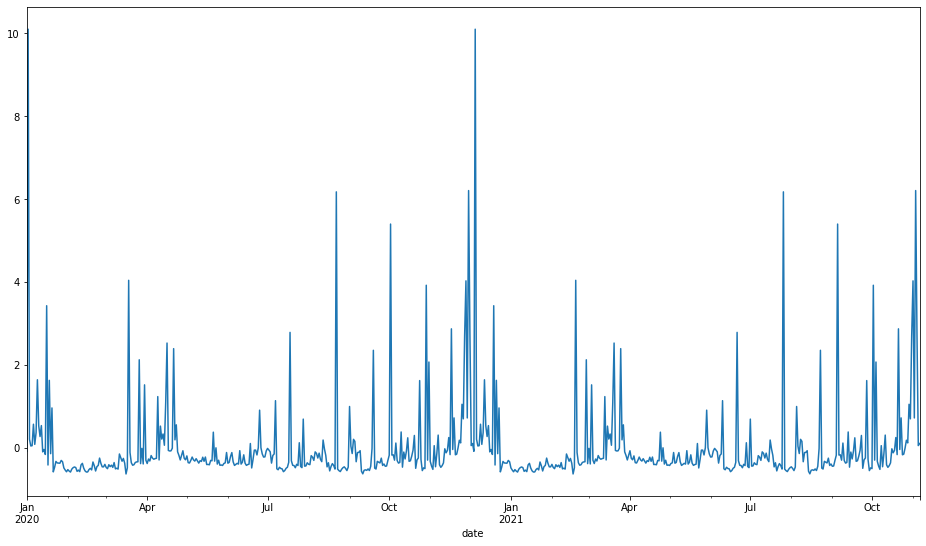

In [ ]:
decompose_result_mult.seasonal.plot()


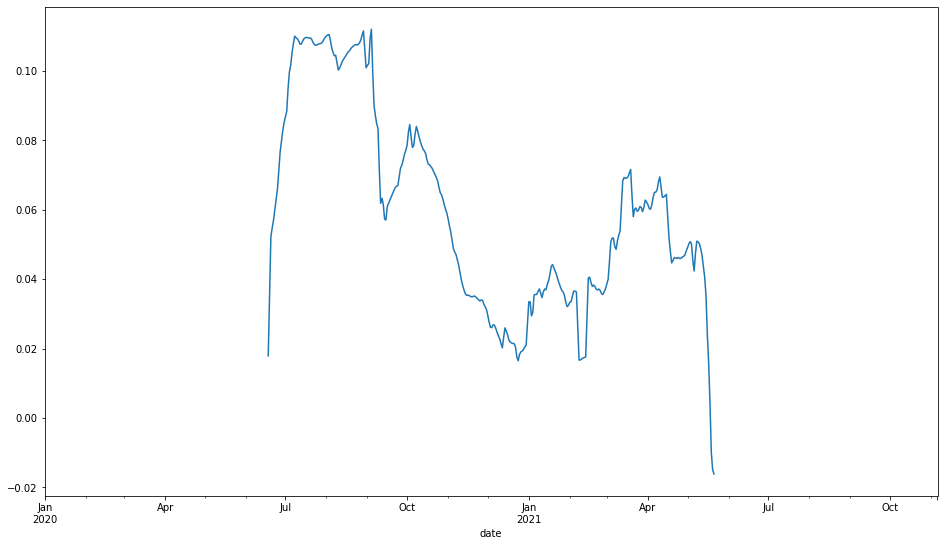

In [ ]:
decompose_result_mult.trend.plot()

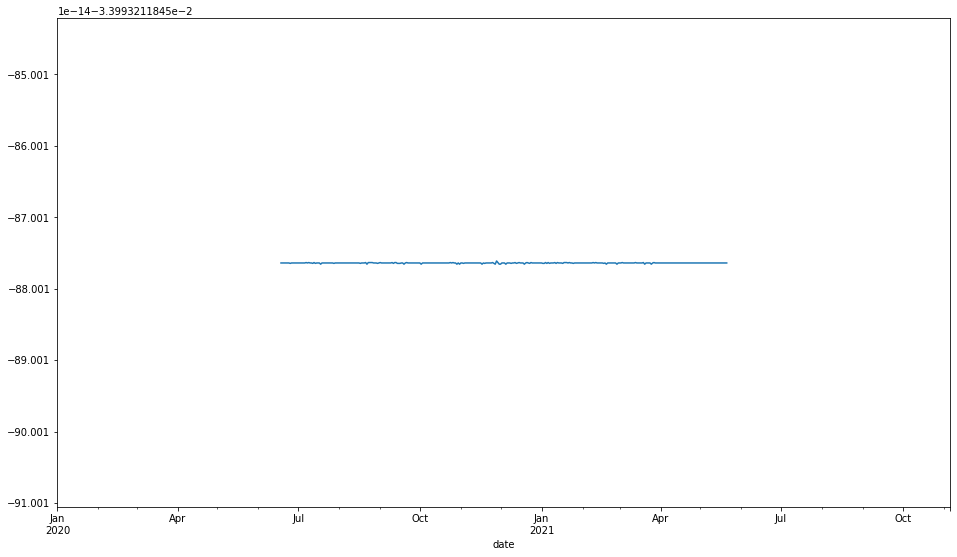

In [ ]:
decompose_result_mult.resid.plot()

We can see that there is a general upward trend in the first half of the dataset, followed by a dip, back to upward trend, and slowly back down. It would be interesting to see why there was a strong dip in ice cream production around 1999.

Seasonality is strong within each year. Warmer months have peak production while winter months have drop offs. This makes sense ice cream consumption is highly related to weather.

### 2.5) Check for stationarity and unit roots

A unit root is in an indication of non-stationary data. Non-stationarity can cause the variance and trend of your data to explore. In order to test for unit roots, and potentially adjust the data if necessary, we can run an ADF test. The ADF Test tests for a unit root in the data. If our p-value is greater than our significance threshold, our we have weak evidence to reject the null hypothesis and our series is non-stationary. Alternatively, if the p-value is less than the significance value we reject the null and conclude that the series is stationary.

In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):

    '''
    This function performs the ADF test for stationarity and prints the output.
    It takes as input a time series and a significance value (defaulted at 0.05)
    '''

    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [ ]:
adfuller_test(df.sales, signif = 0.05)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7644
 No. Lags Chosen       = 4
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Since our data is non-stationary, we need to adjust the data in such a way to make it stationary. I'll take the first difference here and re-test with the ADF test.

In [ ]:
df.sales = df.sales.diff() #first difference
df = df.dropna()
adfuller_test(df.sales, signif = 0.05)

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.6317
 No. Lags Chosen       = 16
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Now the data is stationary, and we can confirm with a visual check.

In [ ]:
fig = px.line(df.sales)
fig.show()

### 2.6) Check for autocorrelation and partial autocorrelation

The autocorrelation and partial autocorrelation functions show us the direct and indirect impacts of past values on current values.


Let's assume we are looking at the last two months impact on today's prediction.

Autocorrelation measures the total effect of past values across the time series on the present values including indirect and direct effects. For example, if we were predicting a value for the month of March the autocorrelation function would factor in the impact of February (indirect effect), but also January (direct effect).

On the other hand, partial autocorrelation measures the direct effect only. Using the same example, if we want to predict a value for March partial autocorrelation would only include the direct effect which measures the correlation from January.

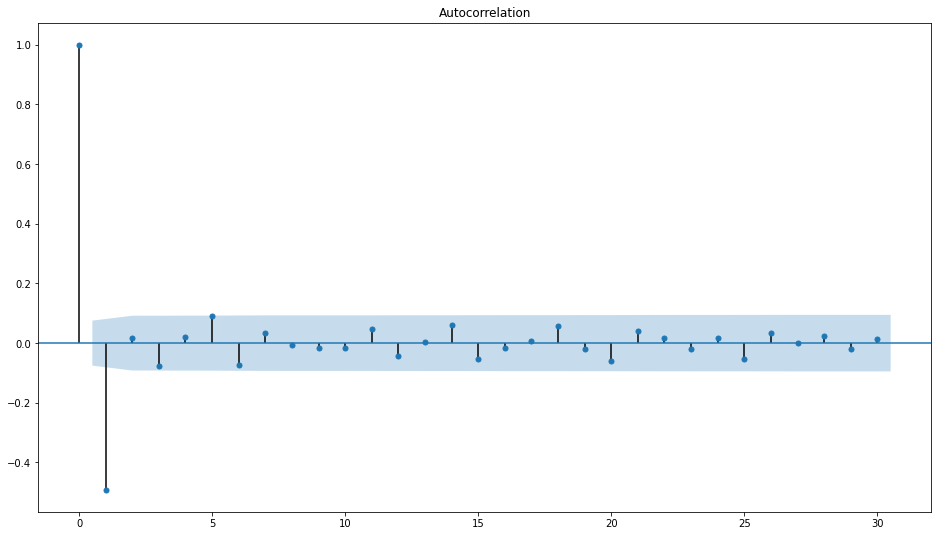

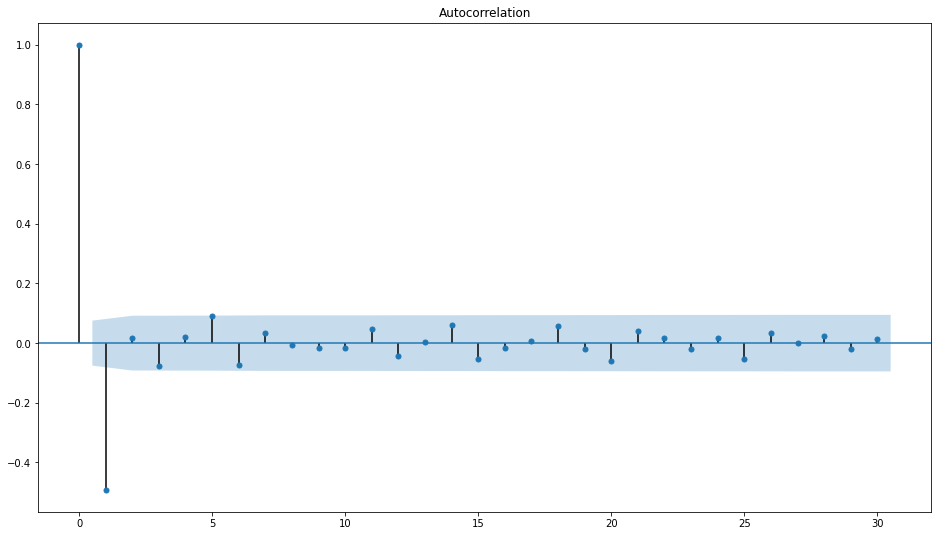

In [ ]:
plot_acf(df.sales, lags = 30) #diminishing process indicating AR

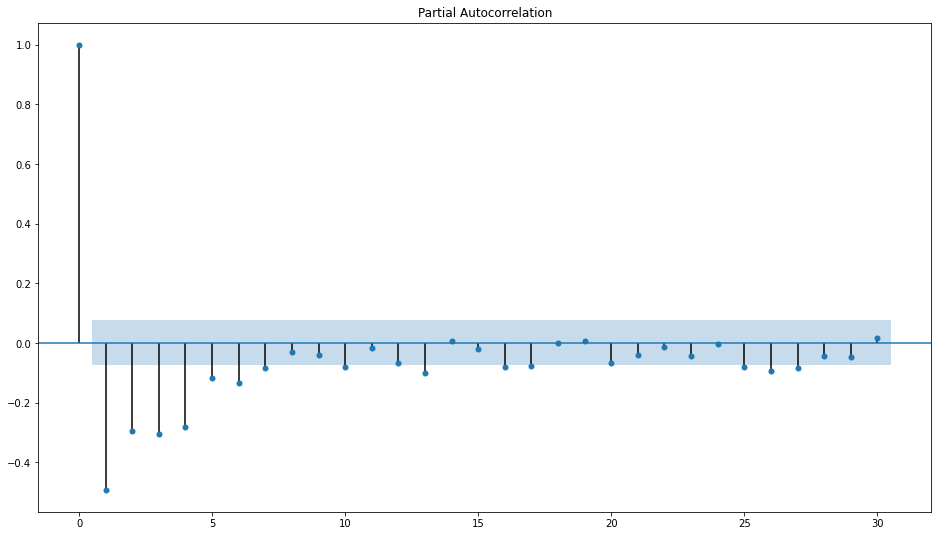

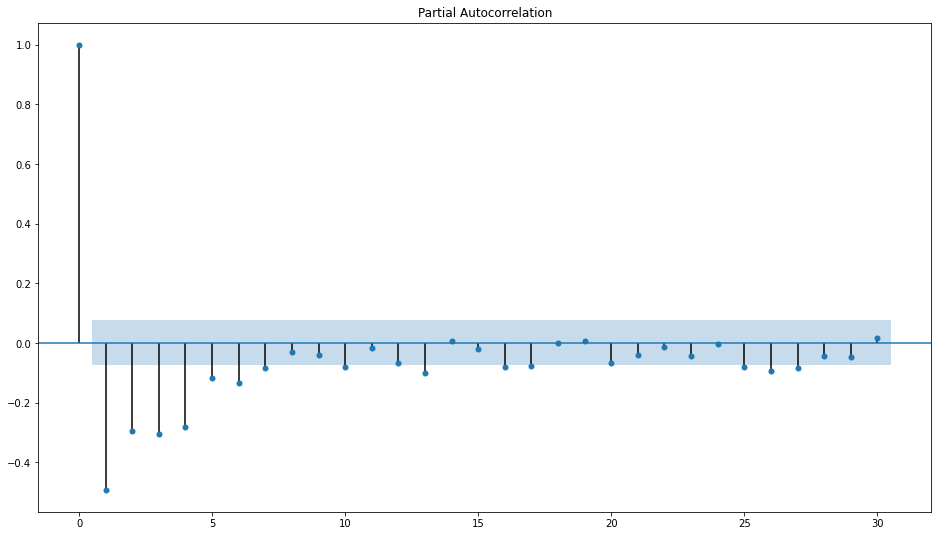

In [ ]:
plot_pacf(df.sales, lags = 30)

These plots are helpful in indicating which lag lengths might be most important to include in a model. Note that this is just a starting point, and you'll want to test many variations in the modeling phase.

The blue bars can be used as a way to measure significant lags. The bars that exceed the blue bars are indicative of predictive power, while those that fall in the blue bars are not.

For the ACF plot here we can see that a decaying trend persists over time. With the PACF we can see the first lag is significant, which indicates that an AR(1) is worth testing.

## 3) Export cleaned data back to BigQuery

In [ ]:
df['date'] = df.index

We can now export the cleaned data series and begin modeling

In [ ]:
destination_project_id = 'db-platform-sol'
destination_dataset = 'joelpunnakkat'
destination_table = "cleaned_adidas_data" #@param
dataset_table = destination_dataset+"."+destination_table

df.to_gbq(dataset_table,
                 destination_project_id,
                 chunksize=None,
                 if_exists='replace'
                 )

1it [00:06,  6.92s/it]
